In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190531

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [3]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190601
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190601


In [4]:
import cs230_project_utilities as utils

In [5]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

# Data

In [7]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

# include class_0?
test_data_locations = dev_data_locations = train_data_locations = ['fastmri-test-tfrecords/*.tfrecord']

# Create preprocessing functions

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=(256, 256),
                                                     use_tiled_reflections=False,
                                                     subsampling_mask_function=None,
                                                     normalize=True)

batch_size = 4
shuffle_buffer_size = 1

# Load data

test_dataset = utils.fastmri.load_dataset(test_data_locations,
                                     batch_size=batch_size,
                                     shuffle_buffer_size=shuffle_buffer_size,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

dev_dataset = utils.fastmri.load_dataset(dev_data_locations,
                                     batch_size=batch_size,
                                     shuffle_buffer_size=shuffle_buffer_size,
                                     include_all_parsed_features=True,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

train_dataset = utils.fastmri.load_dataset(train_data_locations,
                                     batch_size=batch_size,
                                     shuffle_buffer_size=shuffle_buffer_size,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)


# Debugging: make these datasets tiny

test_dataset = test_dataset.take(3)
dev_dataset = dev_dataset.take(3)
train_dataset = train_dataset.take(3)

Loading dataset... Shuffle items? True. Shuffle buffer: 1
Loading dataset... Shuffle items? True. Shuffle buffer: 1
Loading dataset... Shuffle items? True. Shuffle buffer: 1


In [8]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

# Model

In [9]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [10]:
def load_uncompiled_automap_model():

    N = 256
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
    # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
    noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
    # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

    ds1 = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same')(noisy_X)
    ds1 = tf.keras.layers.MaxPool2D(pool_size=2)(ds1) # (new) downsample to spatial dimension: 128

    ds2 = tf.keras.layers.Conv2D(2, (3, 3), strides=(1, 1), activation='relu', padding='same')(ds1)
    ds2 = tf.keras.layers.MaxPool2D(pool_size=2)(ds2) # (new) downsample to spatial dimension: 64

    ds_flat = tf.keras.layers.Flatten()(ds2)

    fc1 = tf.keras.layers.Dense(4096, activation='tanh')(ds_flat)
    fc1 = tf.keras.layers.Dropout(0.05)(fc1)
    fc2 = tf.keras.layers.Dense(4096, activation='tanh')(fc1)
    fc2 = tf.keras.layers.Dropout(0.05)(fc2)
    fc3 = tf.keras.layers.Dense(4096, activation='tanh')(fc2)

    fc_output = tf.keras.layers.Reshape([64, 64, 1])(fc3)

    conv1 = tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    conv1 = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=2, activation='relu', padding='same')(conv1) # (new) upsample to spatial dimension 128

    # L1 regularization to encourage sparsity
    conv2 = tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same',
                                       kernel_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)
    conv2 = tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=2, activation='relu', padding='same',
                                        kernel_regularizer=tf.keras.regularizers.l1(1e-4))(conv2) # (new) upsample to spatial dimension 256

    Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [11]:
def load_compiled_automap_model():
    multi_gpu = False
    # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
    # mirrored strategy). Restricts callbacks we can use
    if multi_gpu:
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
    return model

In [12]:
model = load_compiled_automap_model()

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 2)]     0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 256, 256, 2)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 256)     4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 2)       4610      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0     

# Training

In [23]:
# Custom learning rate schedule


def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    if 0 <= epoch < 100:
        learning_rate = 1e-4
    elif 100 <= epoch < 200:
        learning_rate = 5e-5
    elif 200 <= epoch < 400:
        learning_rate = 2.55e-5
    elif 400 <= epoch < 600:
        learning_rate = 1e-5
    elif 600 <= epoch < 700:
        learning_rate = 2.5e-5
    elif 700 <= epoch < 800:
        learning_rate = 1e-5
    elif 800 <= epoch < 900:
        learning_rate = 1e-6
    else:
        learning_rate = 1e-7

    with file_writer.as_default():
        tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
        
    return learning_rate

# Show reconstructions during training

def plot_fft_reconstructions(batch, logs):
    plot_frequency = 2
    
    if batch % plot_frequency != 0:
        return
    
    batches = [(first_test_batch, 'Test')]#, (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    
    for dataset_batch, name in batches:
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 8)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=batch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=batch)

In [18]:
# Clear logs if necessary
# !rm -r logs/

In [19]:
# Define where logs will be saved

logdir = os.path.join('logs', datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [24]:
# Callback for printing the LR at the end of each epoch.

class PrintAndLogLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            tf.summary.scalar('learning rate (end of epoch)', data=model.optimizer.lr.numpy(), step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                          model.optimizer.lr.numpy()))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_fft_reconstructions)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=1,
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

callbacks = [tensorboard_callback, lr_callback, plot_images_callback, reduce_lr_callback, PrintAndLogLR()]

### Begin training and open Tensorboard to monitor

In [25]:
training_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=2,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/2
      3/Unknown - 65s 22s/step - loss: 3.5579 - mean_PSNR: 10.4228
Learning rate for epoch 1 is 9.999999747378752e-05
3/3 [==============================] - 90s 30s/step - loss: 3.5579 - mean_PSNR: 10.4228 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/2
2/3 [===================>..........] - ETA: 21s - loss: 3.4663 - mean_PSNR: 10.6566
Learning rate for epoch 2 is 9.999999747378752e-05
3/3 [==============================] - 92s 31s/step - loss: 3.4614 - mean_PSNR: 10.5220 - val_loss: 3.3933 - val_mean_PSNR: 12.4181


### Save model (to do: make callback)

In [26]:
# # # Uncomment to save model
# saved_model_path = 'automap_our_dataset_original_paper_model_with_up_down_sampling_single_GPU_small_FC_v6'
# model.save(saved_model_path)

## Evaluate model

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

      3/Unknown - 20s 7s/step - loss: 3.3933 - mean_PSNR: 12.4181

[3.3932509422302246, 12.418121]

### Plot training history (but better viewed in Tensorboard)

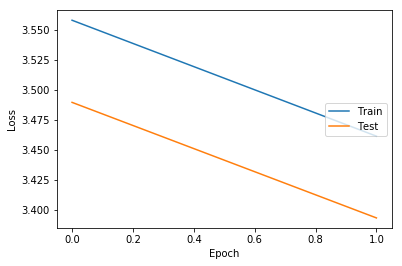

In [29]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

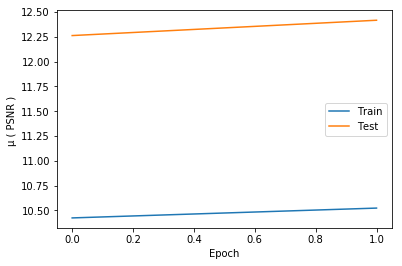

In [30]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

Class: None


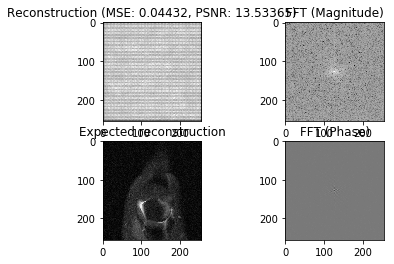

In [31]:
# Predict on a test batch

# batch = next(iter(test_dataset))

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
y_pred = model.predict(x)

# Inspect output

for i in range(len(x)):

    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    c = None #int(cls[i])
    reconstruction = y_pred[i, ..., 0]
    image = y[i, ..., 0]

    print('Class: {}'.format(c))

    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=1.0)

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()
    break


In [48]:
image.shape

(256, 256)

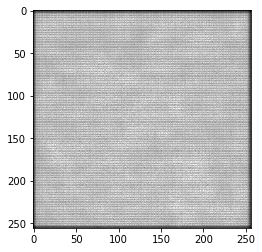

In [45]:
plt.imshow(y_pred[3].squeeze(), cmap='gray')

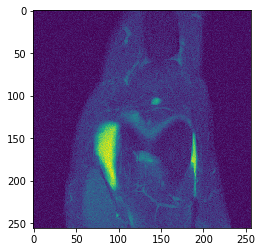

In [47]:
plt.imshow(y[3].squeeze())

In [43]:
utils.signal_processing.mean_square_error(y[3].squeeze(), y_pred[3].squeeze())

0.092192575